In [1]:
'''
Demos written and developed by: Andrew E. Oriani 2020 EMAIL: oriani@uchicago.edu

'''
from PyInventor import *
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time
import datetime

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt

from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm 
from matplotlib.ticker import MaxNLocator

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS
from pyEPR.core_distributed_analysis import CalcObject

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
import os
import re as regex

# Field integrals code
import sys
sys.path.append('../python/src')
import field_integrals as fint

C:\Users\materise1\AppData\Local\anaconda3\envs\tcav\Lib\site-packages\pyepr_quantum-0.9.0-py3.12.egg\pyEPR\ansys.py:82: SyntaxWarning: invalid escape sequence '\d'
C:\Users\materise1\AppData\Local\anaconda3\envs\tcav\Lib\site-packages\pyepr_quantum-0.9.0-py3.12.egg\pyEPR\ansys.py:1583: SyntaxWarning: invalid escape sequence '\$'
C:\Users\materise1\AppData\Local\anaconda3\envs\tcav\Lib\site-packages\pyepr_quantum-0.9.0-py3.12.egg\pyEPR\ansys.py:82: SyntaxWarning: invalid escape sequence '\d'
C:\Users\materise1\AppData\Local\anaconda3\envs\tcav\Lib\site-packages\pyepr_quantum-0.9.0-py3.12.egg\pyEPR\ansys.py:1583: SyntaxWarning: invalid escape sequence '\$'


## Eigenmode solver read from existing HFSS aedt file

In [2]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

In [3]:
def plot_2d_cmap(x, y, z, fname,                                                
                 xstr='', ystr='',                                              
                 tstr='', cbar_str='',                                          
                 cmap=cm.inferno,
                 xyscales={'x' : 'linear', 'y': 'linear'},
                 interp_zeros=False,
                interp_std_dev=10,
                image_rot_angle=0,
                norm_type='linear',
                zref=None, 
                fsize=30,
                tsize=36):
    """                                                                         
    Plot 2D colormap data such that                                             
                                                                                
         -----------------------                                                
         |                     |                                                
         |                     |                                                
    y    |          z          |                                                
         |                     |                                                
         |                     |                                                
         -----------------------                                                
                                                                                
                    x                                                           
                                                                                
    Parameters:                                                                 
    ----------                                                                  
                                                                                
    x, y:       independent variables                                           
    z:          resulting data, z = z(x, y)                                     
    fname:      output figure filename, relative path with file extension       
    xstr:       x-axis label                                                    
    ystr:       y-axis label                                                    
    tstr:       title label                                                     
    cbar_str:   lable for color bar                                             
    cmap:       colormap to use on the 2D figure output                         
                                                                                
    """
    # Interpolate the data
    if interp_zeros:
        hot_pixels, z = fix_outlier_pixels(z, tolerance=interp_std_dev)
    
    # Setup the color map, normalizations, etc
    if norm_type == 'linear':
        norm = mpl.colors.Normalize(z.min(), z.max())
    elif norm_type == 'log':
        if zref:
            norm = mpl.colors.LogNorm(min(zref), max(zref))
        else:
            norm = mpl.colors.Normalize(min(zref), max(zref))    
    elif (norm_type == 'ref') and zref:
        norm = mpl.colors.Normalize(min(zref), max(zref))
    else:
        raise ValueError(f'norm_type ({norm_type}) not recognized')                                         
                                                                                
    # Setup the figure and axes                                                 
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
    
    # Set the scale bar and levels
    if (norm_type == 'ref') and zref:
        levels = MaxNLocator(nbins=20).tick_values(min(zref), max(zref))
    else:
        levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    if image_rot_angle:
        z = scipy.ndimage.rotate(z, image_rot_angle, reshape=True)
    #plt1 = ax.imshow(z, cmap=cmap, norm=norm)
    plt1 = ax.pcolormesh(x, y, z, cmap=cmap, norm=norm)
    ax.set_xlabel(xstr, fontsize=fsize)                                         
    ax.set_ylabel(ystr, fontsize=fsize)                                         
    ax.set_title(tstr, fontsize=tsize)
    
    # Rotate the xlabels. Set both x and y labels to headers[1:]
    ax.set_xscale(xyscales['x'])
    ax.set_yscale(xyscales['y'])
    # set_xaxis_rot(ax, 45)
                                                                                
    # Set the axis tick labels to a reasonable size                             
    set_axes_fonts(ax, fsize)                                                   
                                                                                
    # Set the color bar, offset the title slightly from top                     
    cbar = fig.colorbar(plt1, ax=ax)                                            
    cbar.ax.set_title(cbar_str, fontsize=fsize, y=1.025)                        
    cbar.ax.tick_params(labelsize=fsize)                                        
                                                                                
    # Write the results to file
    print(f'Writing {fname} ...')
    fig.savefig(fname, format='pdf', transparent=True)                  

In [4]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''

def open_hfss_design(project_name : str, design_name : str):
    # Project and HFSS design names for the bare waveguide model
    dd = datetime.datetime.today().strftime('%y%m%d')
    solution_type = 'eigenmode'
    overwrite = False
    
    # # Switch between degenerate and non-degenerate cavities
    # design_name=f'two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweeps_eigenmode2'
    
    #use file location path:
    HFSS_path=os.getcwd()
    
    full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'
    
    HFSS_app=HFSS.HfssApp()
    HFSS_desktop=HFSS_app.get_app_desktop()
    
    project=HFSS_desktop.open_project(full_path)
    
    if project==None:
        project=HFSS_desktop.new_project()
        project.save(full_path)
        
    project.save(full_path)
    project.make_active()
        
    if design_name in project.get_design_names():
        if overwrite==True:
            project.delete_design(design_name)
            project.save()
            
            # Setup a driven modal design type
            if solution_type == 'driven_modal':
                EM_design=project.new_dm_design(design_name)
            elif solution_type == 'eigenmode':
                EM_design=project.new_em_design(design_name)
            else:
                raise ValueError(f'Solution type ({solution_type}) not recognized.')
        else:
            EM_design=project.get_design(design_name)
            
    else:
        if solution_type == 'driven_modal':
            EM_design=project.new_dm_design(design_name)
        elif solution_type == 'eigenmode':
            EM_design=project.new_em_design(design_name)
        else:
            raise ValueError(f'Solution type ({solution_type}) not recognized.')
            
    EM_design.make_active()
    model=HFSS.HfssModeler(EM_design)
    
    project=HFSS_desktop.open_project(full_path)
    
    if project==None:
        project=HFSS_desktop.new_project()
        project.save(full_path)
        
    project.make_active()
        
    if design_name in project.get_design_names():
        if overwrite==True:
            project.delete_design(design_name)
            project.save()
            EM_design=project.new_em_design(design_name)
        else:
            EM_design=project.get_design(design_name)
            
    else:
        EM_design=project.new_em_design(design_name)
            
    EM_design.make_active()
    model=HFSS.HfssModeler(EM_design)

    return EM_design, HFSS_path

## Loop over multiple designs

In [5]:
project_name = 'micromachined_coupler'
design_prefix = 'two_coupled_cavities_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel'
xtunnels = ['', '1', '3', '4', '5', '6', '7']
designs = [f'{design_prefix}{xt}' for xt in xtunnels]
vstr = 'xtunnel'
vunits = 'mm'
hfields_file_format = f'hfields_micromachined_mode_%d_{vstr}_%s.aedtplt'
efields_file_format = f'efields_micromachined_mode_%d_{vstr}_%s.aedtplt'
dpath = 'C:\\Users\\materise1\\tcav\\data\\'
Nmodes = 8

In [10]:
for didx, design in enumerate(designs):
    # Open the HFSS design
    print('-'*30)
    print(f'Starting with design {design} ...')
    print('-'*30)
    print('\n')
    EM_design, HFSS_path = open_hfss_design(project_name, design)

    # Get the sorted variations, if any
    eprh, vstrs, Ljstrs, Ljvals, vars_sorted \
    = get_sorted_variations(HFSS_path, project_name, design, vstr=vstr,
                           vunits=vunits, Nmodes=Nmodes)
    # Export the fields
    ## Update the variation string for different filenames
    vstr_i = f'{vstr}{didx}'
    
    hfield_file_format = dpath + f'hfields_micromachined_mode_%d_{vstr_i}_%s.aedtplt'
    efield_file_format = dpath + f'efields_micromachined_mode_%d_{vstr_i}_%s.aedtplt'

    # Note: vars_sorted=None indicates that we are not using the variations
    #       to drive the EM field exports
    export_em_fields(eprh,
                     EM_design,
                     Nmodes,
                     efields_file_format,
                     hfields_file_format,
                     vstrs = [vstr_i],
                     vars_sorted = vars_sorted)
    print('-'*30)
    print('\n')

------------------------------
Starting with design two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel ...
------------------------------


project_name: micromachined_coupler
path: C:\Users\materise1\tcav\ipynbs\HFSS\micromachined_coupler.aedt
project_name: micromachined_coupler
path: C:\Users\materise1\tcav\ipynbs\HFSS\micromachined_coupler.aedt


INFO 10:21AM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:21AM [load_ansys_project]: 	File path to HFSS project found.
INFO 10:21AM [load_ansys_project]: 	Opened Ansys App
INFO 10:21AM [load_ansys_project]: 	Opened Ansys Desktop v2022.1.0
INFO 10:21AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/materise1/tcav/ipynbs/HFSS/
	Project:   micromachined_coupler
INFO 10:21AM [connect_design]: 	Opened active design
	Design:    two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel [Solution type: Eigenmode]
INFO 10:21AM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:21AM [connect]: 	Connected to project "micromachined_coupler" and design "two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel" 😀 

ERROR 10:21AM [setup_data]: WARNING!   DESIGN FILENAME MAY BE TOO LONG! 


Design "two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel" info:
	# eigenmodes    8
	# variations    1
variations: ("angle_a='54.700000000000003' angle_b='35.299999999999997' cavity_offset='2mm' chip_offset='4mm' h_chip='0.40000000000000002mm' hcav='0.29999999999999999mm' hchip='0.45000000000000001mm' hsub='5mm' leg_length='0.70617532385323001mm' LJ='1nH' ljunc='50um' lpad='-0.050000000000000003mm' ltaper='150um' wjunc='50um' wpad='0.20000000000000301mm' xcav='24mm' xcav_a='24mm' xcav_b='24mm' xchip='28mm' xsub='90mm' xtunnel='8mm' xtunnel0='8mm' xtunnel1='7mm' xtunnel2='6mm' xtunnel3='5mm' xtunnel4='4mm' xtunnel5='3mm' xtunnel6='2mm' ycav='22mm' ycav_a='22mm' ycav_b='22mm' ychip='46mm' ysub='90mm' ytunnel='2mm'",)
Mode-1
omod: <COMObject GetModule>
efields_filename: efields_micromachined_mode_1_xtunnel_xtunnel0.aedtplt
hfields_filename: hfields_micromachined_mode_1_xtunnel_xtunnel0.aedtplt


com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024365), None)

In [43]:
didx = 6 
design = designs[didx]
my_xtunnels = [f'{i}mm' for i in range(8, 1, -1)]
vstr = my_xtunnels[didx]
# Open the HFSS design
print('-'*30)
print(f'Starting with design {design} ...')
print('-'*30)
print('\n')
EM_design, HFSS_path = open_hfss_design(project_name, design)

# Get the sorted variations, if any
eprh, vstrs, Ljstrs, Ljvals, vars_sorted \
= get_sorted_variations(HFSS_path, project_name, design, vstr=vstr,
                       vunits=vunits, Nmodes=Nmodes)
# Export the fields
## Update the variation string for different filenames
vstr_i = f'{vstr}{didx}'
dpath = 'C:\\Users\\materise1\\tcav\\data\\'

hfield_file_format = dpath + f'hfields_micromachined_mode_%d_%s.aedtplt'
efield_file_format = dpath + f'efields_micromachined_mode_%d_%s.aedtplt'

for kp in range(Nmodes):
    # Set the solution to mode kp
    eprh.solutions.set_mode(kp+1)
    # time.sleep(0.5)
    print(f'Mode-{kp+1}')
    des = EM_design._design
    omod = des.GetModule('FieldsReporter')
    efields_filename = efields_file_format % (kp+1, vstr)
    hfields_filename = hfields_file_format % (kp+1, vstr)
    print(f'efields_filename: {efields_filename}')
    print(f'hfields_filename: {hfields_filename}')
    omod.ExportFieldPlot("Vector_E1", False, efields_filename)
    omod.ExportFieldPlot("Vector_H1", False, hfields_filename)

------------------------------
Starting with design two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel7 ...
------------------------------


project_name: micromachined_coupler
path: C:\Users\materise1\tcav\ipynbs\HFSS\micromachined_coupler.aedt
project_name: micromachined_coupler
path: C:\Users\materise1\tcav\ipynbs\HFSS\micromachined_coupler.aedt


INFO 11:45AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:45AM [load_ansys_project]: 	File path to HFSS project found.
INFO 11:45AM [load_ansys_project]: 	Opened Ansys App
INFO 11:45AM [load_ansys_project]: 	Opened Ansys Desktop v2022.1.0
INFO 11:45AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/materise1/tcav/ipynbs/HFSS/
	Project:   micromachined_coupler
INFO 11:45AM [connect_design]: 	Opened active design
	Design:    two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel7 [Solution type: Eigenmode]
INFO 11:45AM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:45AM [connect]: 	Connected to project "micromachined_coupler" and design "two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel7" 😀 

ERROR 11:45AM [setup_data]: WARNING!   DESIGN FILENAME MAY BE TOO LONG! 


Design "two_coupled_cavities_no_jj_no_silicon_version_a_merged_gnd_sidewall_vacuum_full_geom_sweep_xtunnel7" info:
	# eigenmodes    8
	# variations    1
variations: ("angle_a='54.700000000000003' angle_b='35.299999999999997' cavity_offset='2mm' chip_offset='4mm' h_chip='0.40000000000000002mm' hcav='0.29999999999999999mm' hchip='0.45000000000000001mm' hsub='5mm' leg_length='0.70617532385323001mm' LJ='1nH' ljunc='50um' lpad='-0.050000000000000003mm' ltaper='150um' wjunc='50um' wpad='0.20000000000000301mm' xcav='24mm' xcav_a='24mm' xcav_b='24mm' xchip='28mm' xsub='90mm' xtunnel='8mm' xtunnel0='8mm' xtunnel1='7mm' xtunnel2='6mm' xtunnel3='5mm' xtunnel4='4mm' xtunnel5='3mm' xtunnel6='2mm' ycav='22mm' ycav_a='22mm' ycav_b='22mm' ychip='46mm' ysub='90mm' ytunnel='2mm'",)
Mode-1
efields_filename: efields_micromachined_mode_1_xtunnel_2mm.aedtplt
hfields_filename: hfields_micromachined_mode_1_xtunnel_2mm.aedtplt
Mode-2
efields_filename: efields_micromachined_mode_2_xtunnel_2mm.aedtplt
hfields_fi

In [6]:
def get_sorted_variations(HFSS_path : str,
                          project_name : str,
                          design_name : str,
                          vstr : str = 'xtunnel',
                          vunits : str = 'mm',
                          Nmodes : int = 8):
    # Setup the pyEPR project
    pinfo = pyEPR.ProjectInfo(HFSS_path+'\\HFSS',  
                             project_name,
                             design_name)
    # Setup for EPR anaylsis
    eprh = pyEPR.DistributedAnalysis(pinfo)
    
    # Read off the inductances and x-offsets from the variations
    variations = eprh.solutions.list_variations()
    vstr = 'cavity_offset'
    vstr = 'xtunnel'
    vunits = 'mm'
    Ljstrs = []; Ljvals = []
    #xoffstrs = []; xoff_vals = []
    print(f'variations: {variations}')
    for v in variations:
        Ljstrs.append(regex.findall(f'{vstr}=\'(.*?{vunits})', v)[0].replace('.', 'p'))
        Ljvals.append(float(regex.findall(f'{vstr}=\'(.*?){vunits}', v)[0]))

    # Sort the strings by the values
    Lj_sort_idxs = np.argsort(Ljvals)
    Ljvals = np.unique(np.asarray(Ljvals)[Lj_sort_idxs])
    Ljstrs = np.unique(np.asarray(Ljstrs)[Lj_sort_idxs])

    # Variation strings
    vstrs = [f'{vstr}_{l}' for l in Ljstrs]

    # Sort the variations
    vars_sorted = np.asarray(eprh.variations)
    vars_sorted = vars_sorted[Lj_sort_idxs]

    return eprh, vstrs, Ljstrs, Ljvals, vars_sorted

In [7]:
vars_sorted.size

NameError: name 'vars_sorted' is not defined

In [8]:
Ljstrs.size

NameError: name 'Ljstrs' is not defined

## Need to manually create Vector_E plot in GUI first
* TODO: Create a new field plot, then export the field data with ansys.py

In [9]:
def export_em_fields(eprh,
                     EM_design,
                     Nmodes : int,
                     efields_file_format : str,
                     hfields_file_format : str,
                     vstrs : list,
                     vars_sorted : list = None):
    if vars_sorted is not None:
        for idx, v in enumerate(vars_sorted):
            # Set the variation
            eprh.set_variation(v)
            lv = eprh._get_lv(v)
            for kp in range(Nmodes):
                # Set the solution to mode kp
                eprh.solutions.set_mode(kp+1)
                # time.sleep(0.5)
                print(f'Mode-{kp+1}')
                des = EM_design._design
                omod = des.GetModule('FieldsReporter')
                print(f'omod: {omod}')
                efields_filename = efields_file_format % (kp+1, vstrs[idx])
                hfields_filename = hfields_file_format % (kp+1, vstrs[idx])
                print(f'efields_filename: {efields_filename}')
                print(f'hfields_filename: {hfields_filename}')
                # omod.ExportFieldPlot("Vector_E1", False, f"C:\\Users\\materise1\\tcav\\data\\efields_micromachined_mode_{kp+1}_{vstrs[idx]}.aedtplt")
                omod.ExportFieldPlot("Vector_E1", False, efields_filename)
                omod.ExportFieldPlot("Vector_H1", False, hfields_filename)
    else:
        for kp in range(Nmodes):
            # Set the solution to mode kp
            eprh.solutions.set_mode(kp+1)
            # time.sleep(0.5)
            print(f'Mode-{kp+1}')
            des = EM_design._design
            omod = des.GetModule('FieldsReporter')
            efields_filename = efields_file_format % (kp+1, vstrs[0])
            hfields_filename = hfields_file_format % (kp+1, vstrs[0])
            print(f'efields_filename: {efields_filename}')
            print(f'hfields_filename: {hfields_filename}')
            # omod.ExportFieldPlot("Vector_E1", False, f"C:\\Users\\materise1\\tcav\\data\\efields_micromachined_mode_{kp+1}_{vstrs[idx]}.aedtplt")
            omod.ExportFieldPlot("Vector_E1", False, efields_filename)
            omod.ExportFieldPlot("Vector_H1", False, hfields_filename)
    print('Finished writing field data to file.')

In [18]:
# Build a string for each variation to label the output files
Nmodes = 4
for idx, v in enumerate(vars_sorted):
    # Set the variation
    eprh.set_variation(v)
    lv = eprh._get_lv(v)
    print(f'Variation: {vstrs[idx]}')
    for kp in range(Nmodes):
        # Set the solution to mode kp
        eprh.solutions.set_mode(kp+1)
        # time.sleep(0.5)
        print(f'Mode-{kp+1}')
        des = EM_design._design
        omod = des.GetModule('FieldsReporter')
        omod.ExportFieldPlot("Vector_E1", False, f"C:\\Users\\materise1\\tcav\\data\\efields_micromachined_mode_{kp+1}_{vstrs[idx]}.aedtplt")
print('Finished writing field data to file.')

Variation: xtunnel_4mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_4p5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_5p5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_6mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_6p5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_7mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_7p5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_8mm
Mode-1
Mode-2
Mode-3
Mode-4
Finished writing field data to file.


## Need to manually create Vector_H (90 degrees phase) plot in GUI first

In [19]:
# Build a string for each variation to label the output files
Nmodes = 4
for idx, v in enumerate(vars_sorted):
    # Set the variation
    eprh.set_variation(v)
    lv = eprh._get_lv(v)
    print(f'Variation: {vstrs[idx]}')
    for kp in range(Nmodes):
        # Set the solution to mode kp
        eprh.solutions.set_mode(kp+1)
        # time.sleep(0.5)
        print(f'Mode-{kp+1}')
        des = EM_design._design
        omod = des.GetModule('FieldsReporter')
        omod.ExportFieldPlot("Vector_H1", False, f"C:\\Users\\materise1\\tcav\\data\\hfields_micromachined_mode_{kp+1}_{vstrs[idx]}.aedtplt")
print('Finished writing field data to file.')

Variation: xtunnel_4mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_4p5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_5p5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_6mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_6p5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_7mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_7p5mm
Mode-1
Mode-2
Mode-3
Mode-4
Variation: xtunnel_8mm
Mode-1
Mode-2
Mode-3
Mode-4
Finished writing field data to file.


## Run the field integrals code with correct normalization

In [53]:
from importlib import reload
reload(fint)
# Single point of entry inputs to class
Nmodes = 2
modes = np.linspace(1, Nmodes, Nmodes, dtype=int)
print(f'modes: {modes}')
# LJs = np.asarray([0.1, 1., 10., 100.])
# LJstrs = ['0p1', '1', '10']

data_path = ''
# vstr='cavity_offset'
hfield_format = f'hfields_micromachined_mode_%d_{vstr}_%s.aedtplt'
efield_format = f'efields_micromachined_mode_%d_{vstr}_%s.aedtplt'


hfield_format = dpath + f'hfields_micromachined_mode_%d_xtunnel_%s.aedtplt'
efield_format = dpath + f'efields_micromachined_mode_%d_xtunnel_%s.aedtplt'

Ljstrs = my_xtunnels
Lj_vals = np.asarray(list(range(8, 1, -1)))

Nmodes = 2
tic = time.time()
myfields = fint.FieldIntegrals(# eprh,
                 Nmodes, data_path,
                 Lj_vals, np.array([0]*len(Lj_vals)),
                 Ljstrs,
                 hfield_format, efield_format,
                 jjstr=None, LJstr=None,
                 jj_area = None, debug=False,
                 normalize_fields=True)


modes: [1 2]
Integrals will use normalized fields.


In [54]:
tic = time.time()
AE, AH, XE, XH = myfields.solve_AB_matrix_eqs()
toc = time.time() - tic
print(f'Elapsed time: {toc / 3600:.1f} hours')

load_fields() modes: [1 2]
Loading Mode-1 ...
Loading Mode-2 ...
Computing Akkp ...
Running kkp1_1_LJLJp_8mm_8mm ...
Running kkp1_1_LJLJp_8mm_7mm ...
Running kkp1_1_LJLJp_8mm_6mm ...
Running kkp1_1_LJLJp_8mm_5mm ...
Running kkp1_1_LJLJp_8mm_4mm ...
Running kkp1_1_LJLJp_8mm_3mm ...
Running kkp1_1_LJLJp_8mm_2mm ...
Running kkp1_1_LJLJp_7mm_8mm ...
Running kkp1_1_LJLJp_7mm_7mm ...
Running kkp1_1_LJLJp_7mm_6mm ...
Running kkp1_1_LJLJp_7mm_5mm ...
Running kkp1_1_LJLJp_7mm_4mm ...
Running kkp1_1_LJLJp_7mm_3mm ...
Running kkp1_1_LJLJp_7mm_2mm ...
Running kkp1_1_LJLJp_6mm_8mm ...
Running kkp1_1_LJLJp_6mm_7mm ...
Running kkp1_1_LJLJp_6mm_6mm ...
Running kkp1_1_LJLJp_6mm_5mm ...
Running kkp1_1_LJLJp_6mm_4mm ...
Running kkp1_1_LJLJp_6mm_3mm ...
Running kkp1_1_LJLJp_6mm_2mm ...
Running kkp1_1_LJLJp_5mm_8mm ...
Running kkp1_1_LJLJp_5mm_7mm ...
Running kkp1_1_LJLJp_5mm_6mm ...
Running kkp1_1_LJLJp_5mm_5mm ...
Running kkp1_1_LJLJp_5mm_4mm ...
Running kkp1_1_LJLJp_5mm_3mm ...
Running kkp1_1_LJLJp_5mm_

### Compute the bare coupling rates

In [22]:
from importlib import reload
reload(fint)
mypcpl = fint.ParametricCouplings(AE, AH, XE, XH, eprh=eprh,
                                  Nmodes_in=Nmodes, vstr=vstr, vunits=vunits)

wk.shape: (4, 4, 9)
Ljstr.shape: (9,)
Lj_sort_idxs.shape: (9,)


In [23]:
Ljstrs

array(['4mm', '4p5mm', '5mm', '5p5mm', '6mm', '6p5mm', '7mm', '7p5mm',
       '8mm'], dtype='<U5')

In [24]:
Lj_vals

array([4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ])

In [25]:
AE.shape

(9, 9, 4, 4)

In [26]:
XE.shape

(9, 9, 4, 4)

In [27]:
AH.shape

(9, 9, 4, 4)

In [28]:
XH.shape

(9, 9, 4, 4)

In [42]:
wks, gsmsk = mypcpl.get_w_gsms_k(0, units='Hz')
gbs, gtms = mypcpl.get_gbs_gtms_kkp(1, 0, units='Hz')

#### Plot the two-mode squeezing, $g_{\mathrm{tms}, 12}$

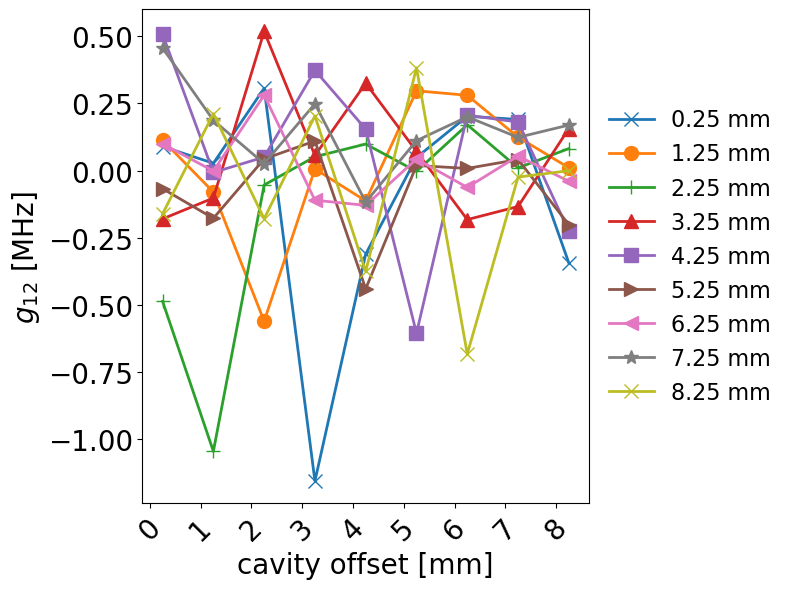

In [191]:
# Plot the modes vs. offset
fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
lsize = 14
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ra0 = 15.0
M = 2
markers = ['x', 'o', '+', '^', 's', '>', '<', '*']
mlen = len(markers)
for i in range(len(Lj_vals)):
    ax.plot(np.asarray(Lj_vals), gtms[i, :] / 1e-3,
            marker=markers[i%mlen], lw=2, ms=10, ls='-',
            label=r'%.2f mm' % (Lj_vals[i]))
ax.set_xlabel(r'cavity offset [mm]', fontsize=fsize)
ax.set_ylabel(r'$g_{12}$ [MHz]', fontsize=fsize)
#ax.set_ylim([-60, 60])
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 16)

#### Plot the coupling, $g_{12}$

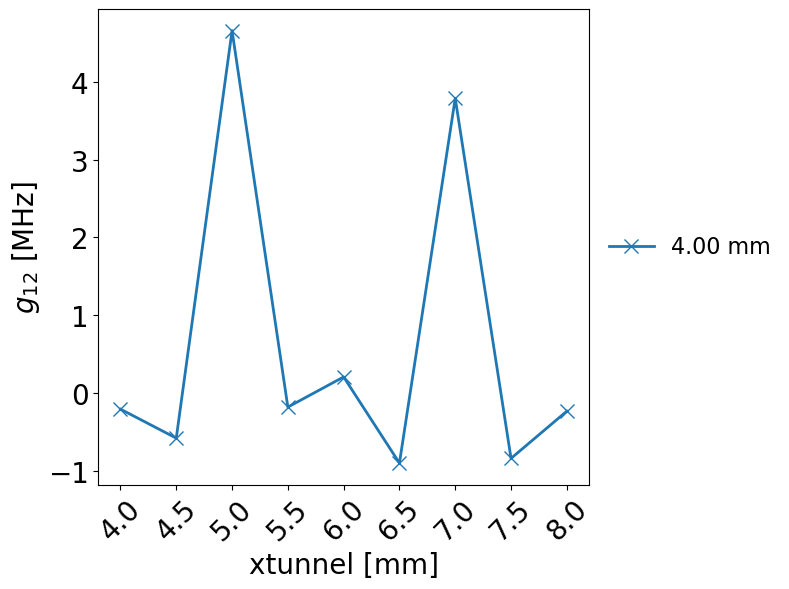

In [43]:
# Plot the modes vs. offset
fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
lsize = 14
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ra0 = 15.0
M = 2
markers = ['x', 'o', '+', '^', 's', '>', '<', '*']
mlen = len(markers)
for i in [0]: # range(len(Lj_vals)):
    ax.plot(np.asarray(Lj_vals), gbs[i, :] / 1e-3,
            marker=markers[i%mlen], lw=2, ms=10, ls='-',
            label=r'%.2f mm' % (Lj_vals[i]))
ax.set_xlabel(f'{vstr} [{vunits}]', fontsize=fsize)
ax.set_ylabel(r'$g_{12}$ [MHz]', fontsize=fsize)
#ax.set_ylim([-60, 60])
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 16)

#### Plot the coupling, $g_{23}$

In [75]:
wks, gsmsk = mypcpl.get_w_gsms_k(0, units='Hz')
gbs, gtms = mypcpl.get_gbs_gtms_kkp(1, 2, units='Hz')

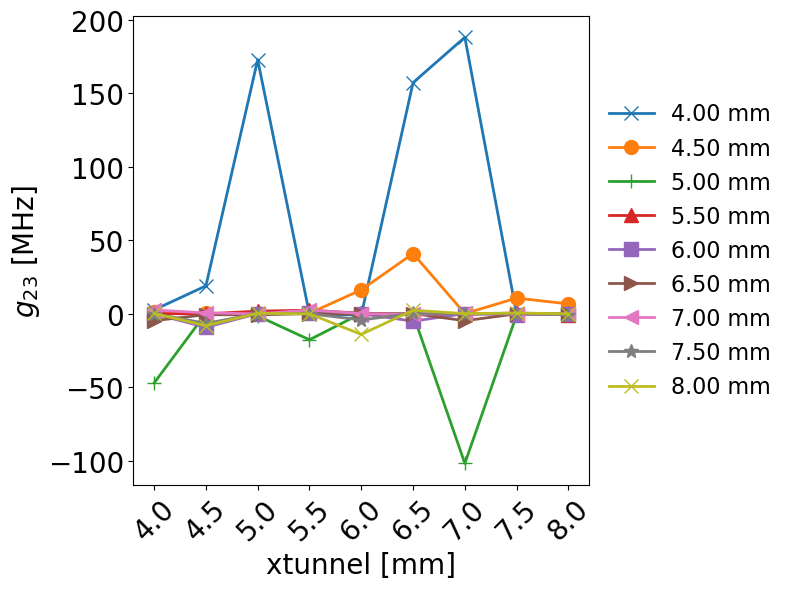

In [76]:
# Plot the modes vs. offset
fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
lsize = 14
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ra0 = 15.0
M = 2
markers = ['x', 'o', '+', '^', 's', '>', '<', '*']
mlen = len(markers)
for i in range(len(Lj_vals)):
    ax.plot(np.asarray(Lj_vals), gbs[i, :] / 1e-3,
            marker=markers[i%mlen], lw=2, ms=10, ls='-',
            label=r'%.2f mm' % (Lj_vals[i]))
ax.set_xlabel(f'{vstr} [{vunits}]', fontsize=fsize)
ax.set_ylabel(r'$g_{23}$ [MHz]', fontsize=fsize)
#ax.set_ylim([-60, 60])
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 16)

#### Plot the coupling $g_{34}$

In [67]:
wks, gsmsk = mypcpl.get_w_gsms_k(0, units='Hz')
gbs, gtms = mypcpl.get_gbs_gtms_kkp(2, 3, units='Hz')

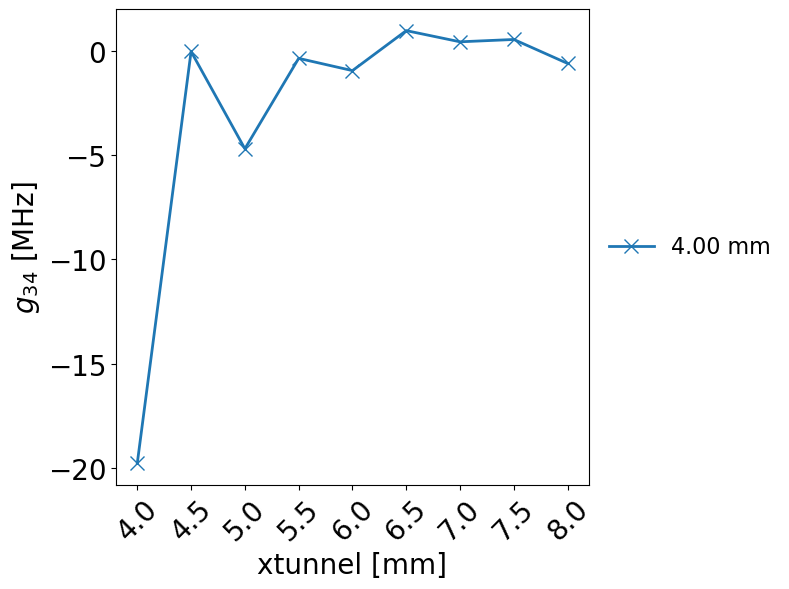

In [68]:
# Plot the modes vs. offset
fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
lsize = 14
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ra0 = 15.0
M = 2
markers = ['x', 'o', '+', '^', 's', '>', '<', '*']
mlen = len(markers)
for i in [0]: #range(len(Lj_vals)):
    ax.plot(np.asarray(Lj_vals), gbs[i, :] / 1e-3,
            marker=markers[i%mlen], lw=2, ms=10, ls='-',
            label=r'%.2f mm' % (Lj_vals[i]))
ax.set_xlabel(f'{vstr} [{vunits}]', fontsize=fsize)
ax.set_ylabel(r'$g_{34}$ [MHz]', fontsize=fsize)
#ax.set_ylim([-60, 60])
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 16)

In [33]:
ww, qq = eprh.solutions.eigenmodes()

## Get the eigenmode frequencies and losses
* Note that frequencies are in GHz here

In [54]:
wk = {}; Qk = {};
for idx, v in enumerate(vars_sorted):
    # Set the variation
    eprh.set_variation(v)
    lv = eprh._get_lv(v)
    print(f'Eigenmodes for variation {vstrs[idx]} ...')
    ww, qq = eprh.solutions.eigenmodes(lv=lv)
    key = f'{vstrs[idx]}'
    wk.update({key : ww})
    Qk.update({key : [ww1/qq1 for ww1, qq1 in zip(ww, qq)]})

Eigenmodes for variation xtunnel_4mm ...
Eigenmodes for variation xtunnel_4p5mm ...
Eigenmodes for variation xtunnel_5mm ...
Eigenmodes for variation xtunnel_5p5mm ...
Eigenmodes for variation xtunnel_6mm ...
Eigenmodes for variation xtunnel_6p5mm ...
Eigenmodes for variation xtunnel_7mm ...
Eigenmodes for variation xtunnel_7p5mm ...
Eigenmodes for variation xtunnel_8mm ...


In [37]:
LJ_dict = dict({k : v for k, v in zip(Ljstrs, Lj_vals)})

In [38]:
LJ_dict

{'4mm': 4.0,
 '4p5mm': 4.5,
 '5mm': 5.0,
 '5p5mm': 5.5,
 '6mm': 6.0,
 '6p5mm': 6.5,
 '7mm': 7.0,
 '7p5mm': 7.5,
 '8mm': 8.0}

## Plot the modes vs. parameter

In [53]:
Ljstrs

array(['4mm', '4p5mm', '5mm', '5p5mm', '6mm', '6p5mm', '7mm', '7p5mm',
       '8mm'], dtype='<U5')

In [1]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
fsize = 20
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
idx_start = 4
Nmodes = 8
for k in range(Nmodes):
    wppp = np.array([wk[f'{vstr}_{key}'][k] for key in Ljstrs])
    ax.plot(Lj_vals, wppp,
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
    #ax.plot(LJs/1e-9, [wp0[idx]/(2*np.pi*fscale)] * len(LJs),
    #        '--', color=cycle[idx%clen])
ax.set_xlabel(f'{vstr} [{vunits}]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
ax.set_ylim([8.7, 9.2])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, lsize)
# ax.set_xscale('log')
fig.savefig(f'../figs/modes_bare_remesh2_nondegen_{dstr}.pdf', 
            format='pdf', bbox_extra_artists=(leg, ), bbox_inches='tight',
           transparent=True)

NameError: name 'plt' is not defined

In [61]:
(wk[f'{vstr}_4mm'][2] - wk[f'{vstr}_4mm'][1]) *1e3

0.13482421999988503

## Q of the modes

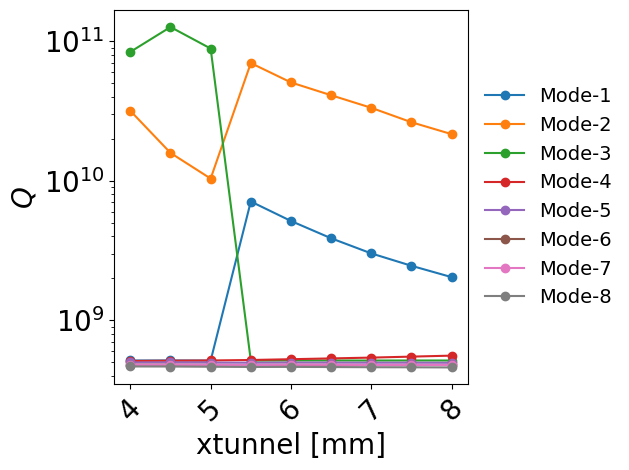

In [62]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale = 1e9
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
T1trans = 100
for k in range(Nmodes):
    Q = np.array([Qk[f'{vstr}_{key}'][k] for key in Ljstrs])
    wppp = 2*np.pi*np.array([wk[f'{vstr}_{key}'][k] for key in Ljstrs])*fscale
    T1nom = wppp / Q
    T1tot = T1nom * T1trans / (T1nom + T1trans)
    ax.plot(Lj_vals, Q,
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
ax.set_xlabel(f'{vstr} [{vunits}]', fontsize=fsize)
ax.set_ylabel(r'$Q$', fontsize=fsize)
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
#ax.set_ylim([1e-2, 350])
#ax.set_xlim([0.5, 2.2])
# ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/T1_modes_coupled_remesh2_eigenmode_{dstr}.pdf',
            format='pdf')

# Plot the eigenmode $T_1$ values

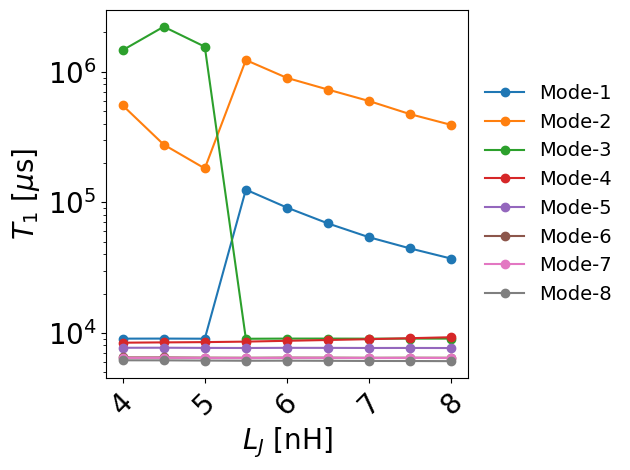

In [64]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale = 1e9
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
T1trans = 100
for k in range(Nmodes):
    Q = np.array([Qk[f'{vstr}_{key}'][k] for key in Ljstrs])
    wppp = 2*np.pi*np.array([wk[f'{vstr}_{key}'][k] for key in Ljstrs])*fscale
    T1nom = 1e6 * Q / wppp
    T1tot = T1nom * T1trans / (T1nom + T1trans)
    ax.plot(Lj_vals, T1nom,
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$T_1$ [$\mu$s]', fontsize=fsize)
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
#ax.set_ylim([1e-2, 350])
#ax.set_xlim([0.5, 2.2])
# ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/T1_modes_coupled_remesh2_eigenmode_{dstr}.pdf',
            format='pdf')

## Compute the $g_{kk'}$ and $\widetilde{\omega}_{k}$ from $A_{kk'}$

In [ ]:
"""
Compute the couplings from Akk, wk values
"""
# Iterate over all modes and inductances
gkk = {}
idx_start = 2; idx_stop = -1
Nmodes = 2
for k in range(Nmodes):
    for kp in range(Nmodes):
        for idx, LJ in enumerate(Lj_vals):
            
            # Outside sqrt(wk wk') factor
            wkey = f'{vstr}_{Ljstrs[idx]}'
            wkwkp = np.sqrt(wk[wkey][k] * wk[wkey][kp])
            
            for idx0, LJ0 in enumerate(Lj_vals):
                
                # Key to index gkk'
                gkey = f'kkp{k+1}_{kp+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                Akkpsum = 0
                print(f'Computing g at {gkey}, wkwkp: {wkwkp:.2e} ...')
                for kpp in range(Nmodes):
                    key = f'kkp{kpp+1}_{k+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                    keyp = f'kkp{kpp+1}_{kp+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                    Akppk = Akkp[key]
                    Akppkp = Akkp[keyp]
                    Akkpsum += Akppk * Akppkp

                # Store the results
                if (k != kp):
                    gkk.update({gkey : wkwkp * Akkpsum})

In [ ]:
'kkp1_1_LJLJp_0p10000000000000001nH_0p10000000000000001nH' in gkk.keys()

### Collect the results as a matrix

In [ ]:
gkk_matrix = np.zeros([Nmodes, Nmodes, len(Lj_vals), len(Lj_vals)])
for k in range(Nmodes):
    for kp in range(Nmodes):
        for idx, LJ in enumerate(Lj_vals):
            for idx0, LJ0 in enumerate(Lj_vals):
                if k != kp:
                    gkey = f'kkp{k+1}_{kp+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                    gkk_matrix[k, kp, idx, idx0] = gkk[gkey]

In [ ]:
gkk_matrix

In [ ]:
"""
Compute the couplings from Akk, wk values
"""
# Iterate over all modes and inductances
wkt = {}
idx_start = 2; idx_stop = -1
Nmodes = 2
for k in range(Nmodes):
    for idx, LJ in enumerate(Lj_vals):

        # Outside wk factor
        wkey = f'{vstr}_{Ljstrs[idx]}'
        wkp = wk[wkey][k]

        for idx0, LJ0 in enumerate(Lj_vals):

            # Key to index gkk'
            wwkey = f'kkp{k+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
            Akkpsum = 0
            # print(f'Computing wkp at {wwkey}, wkwkp: {wkp:.2e} ...')
            for kpp in range(Nmodes):
                key = f'kkp{kpp+1}_{k+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
                Akppk = Akkp[key]
                Akkpsum += Akppk**2

            # Store the results
            wkt.update({wwkey : wkp * Akkpsum})

In [ ]:
len(wkt)

In [ ]:
wkt_matrix = np.zeros([Nmodes, len(Lj_vals), len(Lj_vals)])

## Compute the $\widetilde{\omega}_k(L_J, L_{J_0})$ matrix

In [ ]:
for k in range(Nmodes):
    for idx, LJ in enumerate(Lj_vals):
        for idx0, LJ0 in enumerate(Lj_vals):
            wwkkey = f'kkp{k+1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'
            wkt_matrix[k, idx, idx0] = wkt[wwkkey]

### Sort the frequencies for each $(L_J, L_{J_0})$ pair

In [ ]:
wkt_matrix_sorted = np.sort(wkt_matrix, axis=0)
wkt_sort_idx = np.argsort(wkt_matrix, axis=0)

gkk_sort_idx = wkt_sort_idx[np.newaxis, :, :, :]

In [ ]:
gkk_sort_idx.shape

In [ ]:
gkk_matrix_sorted = gkk_matrix[gkk_sort_idx]

In [ ]:
gkk_matrix_sorted.shape

## Plot the sorted $\widetilde{\omega}_k(L_J, L_{J_0})$ values

In [ ]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)

for idx_fixed in range(len(Lj_vals)):
    print(f'LJ0-{idx_fixed} ...')
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    for k in range(Nmodes):
        ax.plot(Lj_vals, wkt_matrix_sorted[k, :, idx_fixed],
            'o-', label=r'Mode-%d' % (k + 1),
            color=cycle[k%clen])
    ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
    ax.set_ylabel(r'$\widetilde{\omega}/2\pi$ [GHz]', fontsize=fsize)
    set_xaxis_rot(ax, 45)
    set_axes_fonts(ax, fsize)
    leg = set_leg_outside(ax, lsize)
    ax.set_xscale('log')
    fig.savefig(f'../figs/modes_eigenmode_remesh2_modified_LJ0_{Ljstrs[idx_fixed]}_{dstr}.pdf', 
                format='pdf', bbox_extra_artists=(leg, ), bbox_inches='tight',
               transparent=True)

In [ ]:
'kkp1_LJLJp_0p10000000000000001nH_56p234132519034901nH' in wkt.keys()

## Plot $g_{k_1,k_2}$ vs. $L_J, L_{J_0}$

In [ ]:
gmax = np.max(np.array(list(gkk.values()))) * 1e3
gmin = np.min(np.array(list(gkk.values()))) * 1e3

In [ ]:
gmax

In [ ]:
gmin

In [ ]:
#plot_2d_cmap(ydata/ymax,
#    zdata/zmax,
for k1 in [1,2]:
    for k2 in [1, 2]:
        if k1 != k2:
            gkk12 = np.array([[gkk[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
                               for idx in range(len(Lj_vals))] \
                               for idx0 in range(len(Lj_vals))])*1e3
            plot_2d_cmap(# LJs/1e-9,
                #Lj_vals[idx_start:idx_stop],
                #Lj_vals[idx_start:idx_stop],
                Lj_vals,
                Lj_vals,
                np.abs(gkk12),
                # gkk_matrix_sorted[k1, k2, :, :],
                f'../figs/g{k1}_{k2}_remesh2_sorted_vs_rr0_{dd}.pdf',
                xstr=r'$r_{0}$ [mm]',
                ystr=r'$r$ [mm]',
                tstr='',
                xyscales={'x' : 'linear', 'y' : 'linear'},
                cbar_str=r'$g_{%d%d}$ [MHz]' % (k1, k2),
                interp_zeros=False,
                interp_std_dev=3,
                image_rot_angle=0,
                norm_type='ref',
                zref=[0, gmax],
                fsize=40,
                tsize=46)

## Plot $B_{k_1,k_2}(L_{J}, L_{J_0})$ vs. $L_J, L_{J_0}$

In [ ]:
# Amax = np.max(list(Akkp.values()))
# Amin = np.min(list(Akkp.values()))

Bmax = np.max(np.abs(list(Bkkp.values())))
Bmin = np.min(np.abs(list(Bkkp.values())))

In [ ]:
Ljstrs

In [ ]:
Bmin, Bmax

In [ ]:
Amax

In [ ]:
Amin

In [ ]:
for k1 in range(1, Nmodes+1):
    for k2 in range(1, Nmodes+1):

        Akk12 = np.array([[Bkkp[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
                           for idx in range(len(Lj_vals))] \
                           for idx0 in range(len(Lj_vals))])
        
        
        plot_2d_cmap(
            Lj_vals,
            Lj_vals,
            np.abs(Akk12),
            f'../figs/B{k1}_{k2}_two_post_coupler_only_vs_LJLJ0_{dd}.pdf',
            xstr=r'$L_{J_0}$ [nH]',
            ystr=r'$L_{J}$ [nH]',
            tstr='',
            cmap=cm.viridis,
            xyscales={'x' : 'linear', 'y' : 'linear'},
            cbar_str=r'$|B_{%d%d}|$' % (k1, k2),
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            norm_type='log',
            zref=[Bmin, Bmax],
            fsize=40,
            tsize=46)

In [ ]:
Amax = np.max(np.abs(list(Akkp.values())))
Amin = np.min(np.abs(list(Akkp.values())))
for k1 in range(1, Nmodes+1):
    for k2 in range(1, Nmodes+1):

        Akk12 = np.array([[Akkp[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
                           for idx in range(len(Lj_vals))] \
                           for idx0 in range(len(Lj_vals))])
        
        
        plot_2d_cmap(
            Lj_vals,
            Lj_vals,
            np.abs(Akk12),
            f'../figs/A{k1}_{k2}_two_post_coupler_only_vs_LJLJ0_{dd}.pdf',
            xstr=r'$L_{J_0}$ [nH]',
            ystr=r'$L_{J}$ [nH]',
            tstr='',
            cmap=cm.viridis,
            xyscales={'x' : 'linear', 'y' : 'linear'},
            cbar_str=r'$|A_{%d%d}|$' % (k1, k2),
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            norm_type='log',
            zref=[Amin, Amax],
            fsize=40,
            tsize=46)

In [ ]:
Imax = np.max(np.abs(Ikkp))
Imin = np.min(np.abs(Ikkp))
for k1 in range(Nmodes):
    for k2 in range(Nmodes):

        Akk12 = Ikkp[:, :, k1, k2]
        
        plot_2d_cmap(
            Lj_vals,
            Lj_vals,
            np.abs(Akk12),
            f'../figs/I{k1}_{k2}_two_post_coupler_only_vs_LJLJ0_{dd}.pdf',
            xstr=r'$L_{J_0}$ [nH]',
            ystr=r'$L_{J}$ [nH]',
            tstr='',
            cmap=cm.viridis,
            xyscales={'x' : 'log', 'y' : 'log'},
            cbar_str=r'$|I_{%d}I_{%d}|$' % (k1+1, k2+1),
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            norm_type='log',
            zref=[Imin, Imax],
            fsize=40,
            tsize=46)
        

In [ ]:
wmax = np.max(np.array(list(wkt.values())))
wmin = np.min(np.array(list(wkt.values())))

wmax

wmin

#plot_2d_cmap(ydata/ymax,
#    zdata/zmax,
# for k1 in [1,2,3,4]:
for k1 in range(Nmodes):
        # wkk12 = np.array([[wkt[f'kkp{k1}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
        #                   for idx in range(len(Lj_vals))] \
        #                   for idx0 in range(len(Lj_vals))])
        plot_2d_cmap(# LJs/1e-9,
            Lj_vals,
            Lj_vals,
            #wkk12,
            wkt_matrix_sorted[k1, :, :],
            # f'../figs/w_{k1}_vs_LJLJ0_{dd}.pdf',
            f'../figs/w_{k1+1}_remesh2_sorted_vs_LJLJ0_{dd}.pdf',
            xstr=r'$L_{J_0}$ [nH]',
            ystr=r'$L_{J}$ [nH]',
            tstr='',
            xyscales={'x' : 'log', 'y' : 'log'},
            cbar_str=r'$\omega_{%d}$ [GHz]' % (k1),
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            norm_type='ref',
            zref=[wmin, wmax],
            fsize=40,
            tsize=46)

## Compute the derivatives to estimate the driven coupling strengths

dLJ = 1 # 10 nH as a possible driving point
for k1 in [1,2,3,4]:
    for k2 in [1, 2, 3, 4]:
        if k1 != k2:
            gkk12 = np.array([[gkk[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[idx0]}'] \
                               for idx in range(len(Lj_vals))] \
                               for idx0 in range(len(Lj_vals))])
            gkk12_grad = np.array([np.gradient(gkk12[:, j], Lj_vals) for j in range(len(Lj_vals))])
            epskk = gkk12_grad * dLJ * 1e3
            # Write the results to file
            plot_2d_cmap(# LJs/1e-9,
            Lj_vals,
            Lj_vals,
            epskk,
            f'../figs/eps_{k1}_{k2}_remesh2_vs_LJLJ0_{dd}.pdf',
            xstr=r'$L_{J_0}$ [nH]',
            ystr=r'$L_{J}$ [nH]',
            tstr='',
            xyscales={'x' : 'log', 'y' : 'log'},
            cbar_str=r'$\epsilon_{g_{%d %d}}$ [MHz]' % (k1, k2),
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            norm_type='ref',
            zref=[gmin, gmax],
            fsize=40,
            tsize=46)

## Plot $g_{12}$ for a fixed $L_{J_0}$

LJidx0 = 0
dLJ = 10 # 10 nH as a possible driving point
k1 = 1; k2 = 2

fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
fsize = 20
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
idx_start = 4
cidx = 0
for idx0 in [8, 10, 12, 14]:
    gkk12 = np.array([gkk[f'kkp{k1}_{k2}_LJLJp_{Ljstrs[idx]}_{Ljstrs[LJidx0]}'] \
                               for idx in range(len(Lj_vals))])
    gkk12_grad = np.gradient(gkk12, Lj_vals)
    epskk = gkk12_grad * Lj_vals[idx0] * 1e3
    ax.plot(Lj_vals, epskk / 2,
        'o-', color=cycle[cidx%clen],
           label=r'$\delta L_{J}$ = %.2f nH' % Lj_vals[idx0])
    cidx += 1

ax.axhline(y=0, color='k', ls='--')
ax.set_title(r'$L_{J_0} = %.2f$ nH' % Lj_vals[LJidx0],
             fontsize=fsize)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$\frac{1}{2}\epsilon_{g_{%d%d}}$ [MHz]' % (k1, k2), fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.set_ylim([-0.5, 1.5])
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
leg = set_leg_outside(ax, lsize)
fig.savefig(f'../figs/epsg_{k1}{k2}_bbq_1_10_100nH_remesh2_{dstr}.pdf', 
            bbox_extra_artists=(leg, ), bbox_inches='tight',
            format='pdf', transparent=True)

### Get the interpolating sweep data to estimate resonance positions

In [ ]:
fsweep_interp = HFSS.HfssFrequencySweep(DM_setup, 'Interpolating_0')

report_im = fsweep_interp.create_report('Interpolating_0', expr='im(Y(1,1))')
yim = report_im.get_arrays()

# Identify the zero crossings as resonances
zero_xing_idxs = np.where(np.diff(np.sign(yim[1,:])) > 0)[0]
resonances = yim[0,zero_xing_idxs]

print(f'resonances: {resonances}')

In [ ]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
#wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
#get_wp_Cp_Lp(fdata, ydata, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(yim[0,:], yim[1,:], '-', label='Zero Crossings')
ax.plot(resonances,
        yim[1,zero_xing_idxs],
        'o', label='Zero Crossings')
# ax.set_xlim([5.8, 6.1])
ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, ls='--', color='k')
# ax.plot(fdata, ydata.imag)
set_xaxis_rot(ax, 45)
ax.set_ylabel(r'Im $Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)

In [ ]:
resonances

#### Bypass the interpolating sweep if frequencies already known

In [ ]:
# resonances = np.array([ 6.0928,  6.1684,  6.1692,  6.2692,  7.3356,  7.3816,  7.4712,
#        7.506 ,  9.3064,  9.3292,  9.588 ,  9.6076, 11.5804, 11.6684,
#       11.7568, 11.95  , 12.604 , 12.6944, 12.8012, 12.8048])
# resonances = np.array([ 6.0928,  6.1692,  6.2692,  7.3816,  7.4712,
#        7.506 , 9.3292,  9.588 ,  9.6076, 11.5804, 
#       11.7568, 11.95, 12.6944, 12.8048])

# Use half the minimum spacing between resonances as a the bandwidth
Nmodes = 10
# resonances = resonances[0:Nmodes]
df = 0.8 * np.diff(np.hstack((f1, resonances, f2))).min()

In [ ]:
df

### Discrete sweep to resolve resonances

In [ ]:
if solution_type == 'driven_modal':
    # Setup the driven-modal simulation
    if not DM_setup:
        DM_setup = EM_design.create_dm_setup()
        
    # Discrete count
    count2 = 201
    count1 = 51
    
    ## This should resolve the issue of overlapping sweeps
    ## We advance the left boundary by a small amount away
    ## from the previous right boundary
    dff = df / count
    
    # Identify resonances from interpolating sweep manually (for now)
    ## Start at the first sweep frequency
    f1r = f1
    
    # df  = 0.01 # 10 MHz window
    # Iteratve over all resonances and shift the discrete
    # sweep window from f1r to f2r
    rlen = len(resonances)
    fdata = np.array([])
    ydata = np.array([])
    for ridx, fr in enumerate(resonances):
        try:
            # First sweep from f1 to fr_j - df / 2
            f2r = fr - df / 2
            print(f'[{2*ridx} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
            DM_setup.insert_sweep(f1r, f2r,
                                  count=count1,
                                  save_fields=True,
                                  name=f'Discrete_Sweep_{2*ridx}',
                                  type='Discrete')
            DM_setup.solve()

            # Get data from first sweep
            print(f'Creating even reports ...')
            fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*ridx}')
            # report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='re(Y(LumpPort,LumpPort))')
            # report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='im(Y(LumpPort,LumpPort))')
            report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='re(Y(1, 1))')
            report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='im(Y(1, 1))')
            yre = report_re.get_arrays()
            yim = report_im.get_arrays()
            fdata = np.hstack((fdata, yre[0,:]))
            ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))    

            # Backup data to file
            print(f'Backing up even reports ...')
            with open(f'../data/ydata_{dd}_sweep_{2*ridx}.csv', 'w') as fid:
                fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                                     for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

            # Second sweep from fr_j - df / 2 to fr_j + df / 2
            f1r = f2r + dff
            f2r = fr + df / 2
            print(f'[{2*ridx+1} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
            DM_setup.insert_sweep(f1r, f2r,
                                  count=count2,
                                  save_fields=True,
                                  name=f'Discrete_Sweep_{2*ridx+1}',
                                  type='Discrete')
            DM_setup.solve()

            # Get data from first sweep
            print(f'Creating odd reports ...')
            fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*ridx+1}')
            # report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='re(Y(LumpPort,LumpPort))')
            # report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='im(Y(LumpPort,LumpPort))')
            report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='re(Y(1, 1))')
            report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='im(Y(1, 1))')
            yre = report_re.get_arrays()
            yim = report_im.get_arrays()
            fdata = np.hstack((fdata, yre[0,:]))
            ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))    

            # Backup data to file
            print(f'Backing up even reports ...')
            with open(f'../data/ydata_{dd}_sweep_{2*ridx+1}.csv', 'w') as fid:
                fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                                     for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

            # Next sweep from fr_j + df / 2 to fr_j+1 - df / 2
            f1r = f2r + dff
    
        except Exception as e:
            print(f'Exception on run {ridx}:\n{e}')
            continue
    
    # Last frequency band from fr_j + df / 2 to f2
    f2r = f2
    print(f'[{2*rlen} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
    DM_setup.insert_sweep(f1r, f2r,
                          count=count1,
                          save_fields=True,
                          name=f'Discrete_Sweep_{2*rlen}',
                          type='Discrete')
    DM_setup.solve()
    
    # Get data from first sweep
    print(f'Creating last report ...')
    fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*rlen}')
    # report_re = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='re(Y(LumpPort,LumpPort))')
    # report_im = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='im(Y(LumpPort,LumpPort))')
    report_re = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='re(Y(1, 1))')
    report_im = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='im(Y(1, 1))')
    yre = report_re.get_arrays()
    yim = report_im.get_arrays()
    fdata = np.hstack((fdata, yre[0,:]))
    ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))

    # Backup data to file
    print(f'Backing up even reports ...')
    with open(f'../data/ydata_{dd}_sweep_{2*rlen}.csv', 'w') as fid:
        fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                             for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

## --------------------------------------------------------

## Postprocessing, blackbox quantization

In [ ]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False,
                GJ0=7.748e-10):
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
    if LJ0 and GJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
             + 1j * fcpy * 2 * np.pi * CJ0 \
             + GJ0
    yim = ycpy.imag
    zero_xing_idxs = np.where(np.diff(np.sign(yim))>0)[0]
    wp = 2 * np.pi * fcpy[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Compute the capacitances from the derivatives
    ypp = np.gradient(ycpy, 2*np.pi*(fcpy[1]-fcpy[0]))
    Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Lp = 1. / (wp**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    Rp = 1. / np.abs(np.real(ycpy[zero_xing_idxs]))
    Qp = wp * Rp * Cp
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    if LJ0 and CJ0:
        # Compute the Josephson inductive and charging energies
        Ej = (Phi0 / (2 * np.pi))**2 / LJ0
        Ec = e**2 / (2 * (sum(Cp)+CJ0))

        # Compute inductive energies, EL
        EL = 0.5 * Phi0**2 / Lp

        # Compute the phase zero point fluctuations
        GQ = 2 * e**2 / h
        phip2 = 2 * np.pi * GQ * Zp

        # Compute the participations
        # p = phi2 * 2 * Ej / (hbar * wp)
        pl = Lp / LJ0
        pc = Cp / CJ0

        # Compute the gs / Ds
        Zq = np.sqrt(LJ0 / CJ0)
        gD = np.sqrt(Zp / Zq)

        # Compute the g's in units of Hz, divide by h to get v, Ej = hv
        gpq = (2 * np.pi * GQ * Ej / 24.) * sum(phip2) * np.asarray([[
            np.sqrt(Zpp * Zqq) / h for p, Zpp in enumerate(Zp)]
                               for q, Zqq in enumerate(Zp) ])
        gpq = gpq.reshape([len(gpq), len(gpq)])
        
        # Compute the chis, anharmonicities
        # In units of Hz
        chipp  = -Ec * gD**2 / h
        chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                             for p in range(len(chipp))
                             for q in range(len(chipp))])
        chippp = chippp.reshape([len(chipp), len(chipp)])

        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gpq, chippp
    
    else:
        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, None, None, None, None

In [ ]:
def FtoMHz(C):
    """
    Converts Farads to MHz
    """
    MHz  = 1e6
    h    = 6.62607015e-34 
    e    = 1.602176634e-19
    Ec   = e**2 / (2 * C)
    return Ec / h / MHz

In [ ]:
def HtoGHz(L):
    """
    Converts Henrys to GHz
    """
    GHz  = 1e9
    h    = 6.62607015e-34 
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    EJ   = (Phi0 / (2 * np.pi))**2 / L
    return EJ / h / GHz

## Load y-data from files if not-overwrite

In [ ]:
def load_ydata_from_sweeps(resonances):
    fdata = np.array([])
    ydata = np.array([], dtype=complex)

    # Iterate over all discrete frequency sweeps
    for i in range(2*len(resonances)+1):
        report_re = fsweep_interp.create_report(f'Discrete_Sweep_{i}', expr='re(Y(LumpPort,LumpPort))')
        report_im = fsweep_interp.create_report(f'Discrete_Sweep_{i}', expr='im(Y(LumpPort,LumpPort))')
        yre = report_re.get_arrays()
        yim = report_im.get_arrays()

        fdata = np.hstack((fdata, yre[0,:]))
        ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))
    
    return fdata, ydata

In [ ]:
def load_ydata_from_txt(filenames, delimiter=','):
    fdata = np.array([])
    ydata = np.array([], dtype=complex)
    # Iterate over all discrete frequency sweeps
    for fname in filenames:
        print(f'Reading {fname} ...')
        data = np.genfromtxt(fname, delimiter=delimiter).T
        f   = data[0]
        yre = data[1]
        yim = data[2]

        fdata = np.hstack((fdata, f))
        ydata = np.hstack((ydata, yre + 1j*yim))
    return fdata, ydata

In [ ]:
if not overwrite:
    res_in = np.zeros(21)
    fdata, ydata = load_ydata_from_files(res_in)

In [ ]:
filenames = [f'../data/ydata_230418_sweep_{i}.csv' for i in range(3)]
#for f in [f'../data/ydata_230326_sweep_{i}.csv' for i in range(3)]:
#    filenames.append(f)
fdata1, ydata1 = load_ydata_from_txt(filenames)

In [ ]:
ydata1

In [ ]:
fdata1

In [ ]:
fdata.size

In [ ]:
ydata.size

## Plot the zero crossings

In [ ]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
dstr = datetime.datetime.today().strftime('%y%m%d')
wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
get_wp_Cp_Lp(fdata1, ydata1, LJ0=100e-9, CJ0=2e-15, fscale=1e9, use_Zq=False)

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(fdata1, ydata1.imag)
ax.plot(wp/(2*np.pi*fscale), yp.imag, 'o', label='Zero Crossings')
ax.set_ylabel(r'Im $Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)
set_xaxis_rot(ax, 45.)
#ax.set_xlim([None, 10])
#ax.set_xlim([5.88, 5.95])
ax.set_ylim([-0.05, 0.05])
ax.axhline(y=0, color='k', ls='--')
fig.savefig(f'../figs/zeros_term_bbq_inductive_50um_15mm_{dstr}.pdf', format='pdf')

## Iterate over all coupler offset values, fix LJ=10 nH

In [ ]:
def get_bbq_params(fdata, ydata, NLJ=25, Nmodes=6, LJvals=[0.1e-9, 100e-9]):
    wps = []
    pcs = []
    pls = []
    gDs = []
    Cps = []
    Lps = []
    Qps = []
    chis = []

    # Whether or not to use the largest impedance mode
    # as the junction mode in the calculations
    use_Zq = False
    print_results = True

    LJs = np.logspace(np.log10(LJvals[0]), np.log10(LJvals[1]), NLJ)
    #for idx, x in enumerate(xdata):
    for LJ in LJs:
        wpp, Lp, Cp, Qp, _, _, _, pl, pc, gD, chip \
        = get_wp_Cp_Lp(fdata, ydata, LJ0=LJ, fscale=fscale, use_Zq=use_Zq)
        wps.append(np.sort(wpp[0:Nmodes]))
        #wps.append(wpp[0:Nmodes])
        pls.append(pl[0:Nmodes])
        pcs.append(pc[0:Nmodes])
        gDs.append(gD[0:Nmodes, 0:Nmodes])
        Lps.append(Lp[0:Nmodes])
        Cps.append(Cp[0:Nmodes])
        Qps.append(Qp[0:Nmodes])
        chis.append(chip[0:Nmodes, 0:Nmodes])
        if print_results:
            print(f'wps: {wps}')
        # wps.append(wpp)
        # print(f'LJ: {LJ}, wpp: {wpp}')
    wps = np.asarray(wps).T
    pls  = np.asarray(pls).T
    pcs  = np.asarray(pls).T
    gDs = np.asarray(gDs).T
    Lps = np.asarray(Lps).T
    Cps = np.asarray(Cps).T
    Qps = np.asarray(Qps).T
    chis = np.asarray(chis).T

    return wps, pls, pcs, gDs, Lps, Cps, Qps, chis

In [ ]:
wp0,_ , _, _, _, _, _, _, _, _, _ = get_wp_Cp_Lp(fdata, ydata, fscale=fscale, LJ0=None)

In [ ]:
wps1, pls1, pcs1, gDs1, Lps1, Cps1, Qps1, chis1 = get_bbq_params(fdata, ydata, Nmodes=1, LJvals=[1e-9,100e-9])

In [ ]:
Cps1

In [ ]:
FtoMHz(Cps1[0])

## Plot the $E_C$ of the coupler mode

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NLJ = 25
LJs = np.logspace(np.log10(1e-9), np.log10(100e-9), NLJ)
ax2 = ax.twinx()
for idx, wppp in enumerate(wps1):
    ax.plot(LJs/1e-9, FtoMHz(Cps1[0]),
            'o',
            color=cycle[idx%clen], label=r'$E_C$ [MHz]')
    ax2.plot(LJs/1e-9, HtoGHz(LJs),
           '*', color=cycle[(idx+1)%clen],
            label=r'$E_J$ [GHz]')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$E_C$ [MHz]', fontsize=fsize)
ax2.set_ylabel(r'$E_J$ [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim([7.165, 7.2])
set_axes_fonts(ax, fsize)
set_axes_fonts(ax2, fsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
            transparent=True, format='pdf')

In [ ]:
wps1[2]

In [ ]:
wps1[:, 0]

In [ ]:
wps1[:, -1]

In [ ]:
wps1_sort = np.sort(wps1, axis=0)
wps1_sort

## Plot the modes of coupled structure

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NLJ = 25
LJs = np.logspace(np.log10(1e-9), np.log10(100e-9), NLJ)
for idx, wppp in enumerate(wps1):
    ax.plot(LJs/1e-9, wppp/(2*np.pi*fscale),
            'o', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
    ax.plot(LJs/1e-9, [wp0[idx]/(2*np.pi*fscale)] * len(LJs),
            '--', color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim([7.165, 7.2])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='pdf')

## Plot the splittings of the lowest modes vs LJ

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ax.plot(LJs/1e-9, (wps1[1]-wps1[0])/(2*np.pi*fscale2),
           'o-',
            color=cycle[0%clen])
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode Splitting (1,2) [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
#ax.set_ylim([0, 150])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
fig.savefig(f'../figs/modes_splitting_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
            format='pdf')

## Mode losses

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Q in enumerate(Qps1):
    ax.plot(LJs/1e-9, 1./Q,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$Q_p^{-1}$', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_losses_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

## Mode $T_1$'s

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Q in enumerate(Qps1):
    ax.plot(LJs/1e-9, 1e6 * Q / wps1[idx],
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.plot(LJs/1e-9, 100*np.ones(LJs.size), 'k:',
        lw=2, label=r'100 $\mu$s $T_1$')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$T_1$ [$\mu$s]', fontsize=fsize)
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
#ax.set_ylim([1e-2, 350])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/T1_modes_coupled_{dstr}.pdf',
            format='pdf')

## Black box results

### $\alpha_p$ and $\chi_{pq}$

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
fscale3 = 1e3
for idx in range(Nmodes):
    ax.plot(LJs/1e-9, 0.5 * np.abs(chis1[idx, idx, :]) / fscale3,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\alpha_p|$ [kHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_alpha_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [ ]:
# Chi, lower triangle
chiT = np.array([np.triu(chis1[:,:,i]) for i in range(len(LJs))]).T
gT = np.array([np.triu(gDs1[:,:,i]) for i in range(len(LJs))]).T
NM = 4
chiT[0:NM,0:NM,0]

fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NM = 4
idx = 0
for i in range(NM):
    for j in range(NM):
        if (i != j) and np.any(chiT[i, j, :] != 0.):
            ax.plot(LJs/1e-9, np.abs(chiT[i, j, :]) / fscale3,
                'o-', label=r'$\chi_{%d,%d}$' % (i + 1, j + 1),
                color=cycle[idx%clen])
            idx += 1
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\chi_{pq}|$ [kHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_chi_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NM = 4
idx = 0
for i in range(NM):
    for j in range(NM):
        if (i != j) and np.any(gT[i, j, :] != 0.):
            ax.plot(LJs/1e-9, np.abs(gT[i, j, :]) / fscale2,
                'o-', label=r'$g_{%d,%d}$' % (i + 1, j + 1),
                color=cycle[idx%clen])
            idx += 1
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|g_{pq}|$ [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_g_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')